# ISTAT NIC - Extract and Merge NIC Data

This notebook extracts NIC (Nuclei familiari con Indice dei Consumi) data from multiple ISTAT sources and merges them into a single time series.

## Data Sources

### 1. Excel File (1996-2015)
- **File**: `data/istat/nic_1996_2015.xls`
- **Tab**: EN
- **ECOICOP**: 00
- **Level**: Gen.
- **Period**: From January 1996 to December 2015

### 2. Compressed CSV File (2016-2025)
- **File**: `data/istat/NIC_2016_2025M11.tar.gz`
- **Filters**:
  - Territorio = Italia
  - MEASURE = 4
  - E_COICOP_REV_ISTAT = 0
  - ECOICOP Rev. Istat = Indice generale
- **Period**: From January 2016 onwards

## Output

The notebook:
1. Extracts data from the Excel file (1996-2015)
2. Extracts data from the tar.gz file (2016-2025)
3. Creates individual plots for each series
4. Merges both series into a single dataset
5. Creates a final plot showing the transition point between the two data sources
6. Saves the merged data to `data/istat/NIC_MONTHLY.csv` with columns:
   - **TIME_PERIOD**: Date period (YYYY-MM format)
   - **OBS_VALUE**: Observation value

## Generated Files

- `data/istat/NIC_MONTHLY.csv`: Merged monthly data (1996-2025)
- `data/istat/NIC_MONTHLY_plot.png`: Plot of the 1996-2015 series
- `data/istat/NIC_MONTHLY_2016_2025_plot.png`: Plot of the 2016-2025 series
- `data/istat/NIC_MONTHLY_merged_plot.png`: Final plot showing both series with transition point


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Change to project root directory
# Find the project root by looking for the 'data' directory
current_dir = os.getcwd()
while not os.path.exists(os.path.join(current_dir, 'data')):
    parent_dir = os.path.dirname(current_dir)
    if parent_dir == current_dir:
        # Reached filesystem root without finding 'data' directory
        raise FileNotFoundError("Could not find project root directory (looking for 'data' folder)")
    current_dir = parent_dir

os.chdir(current_dir)
print(f"Working directory: {os.getcwd()}")

# Define input and output files
input_file = 'data/istat/nic_1996_2015.xls'
output_file = 'data/istat/NIC_MONTHLY.csv'
output_dir = 'data/istat'

# Check that the input file exists
if not os.path.exists(input_file):
    raise FileNotFoundError(f"File not found: {input_file}")

print(f"Input file: {input_file}")
print(f"Output file: {output_file}")


Working directory: /workspace
Input file: data/istat/nic_1996_2015.xls
Output file: data/istat/NIC_MONTHLY.csv


## Read Excel File

Read the Excel file and analyze its structure to find the row with ECOICOP=00 and level=Gen.


In [2]:
# Read the Excel file, specifically the "EN" tab
# Structure: 
# - Row 10 (index 10): Header row with ECOICOP, level, denominations, and monthly dates
# - Row 11 onwards: Data rows with ECOICOP codes, levels, and monthly values in columns
print(f"\n{'='*60}")
print("Reading Excel file structure...")
print(f"{'='*60}")

try:
    # Read the full file without header
    df_full = pd.read_excel(input_file, sheet_name='EN', header=None, engine='xlrd')
    
    print(f"Full data shape: {df_full.shape}")
    
    # Get header row (row 10, index 10)
    header_row = df_full.iloc[10]
    print(f"\nHeader row (row 10, first 15 columns):")
    print(header_row.iloc[:15].tolist())
    
    # Find the row with ECOICOP=00 and level=Gen.
    # This should be row 11 (index 11) based on the structure
    print(f"\n{'='*60}")
    print("Searching for ECOICOP=00 and level=Gen...")
    print(f"{'='*60}")
    
    target_row_idx = None
    for idx in range(11, min(len(df_full), 100)):  # Start from row 11, check first 100 rows
        row = df_full.iloc[idx]
        # Check if first column contains '00' and second column contains 'Gen.'
        first_col = str(row.iloc[0]).strip() if pd.notna(row.iloc[0]) else ''
        second_col = str(row.iloc[1]).strip() if pd.notna(row.iloc[1]) else ''
        
        if first_col == '00' and 'Gen.' in second_col:
            target_row_idx = idx
            print(f"\nFound target row at index {idx}:")
            print(f"  Column 0 (ECOICOP): {first_col}")
            print(f"  Column 1 (level): {second_col}")
            print(f"  Column 2 (description): {row.iloc[2] if pd.notna(row.iloc[2]) else 'N/A'}")
            print(f"  First few values: {row.iloc[3:8].tolist()}")
            break
    
    if target_row_idx is None:
        raise ValueError("Could not find row with ECOICOP=00 and level=Gen.")
    
    print(f"\nTarget row index: {target_row_idx}")
    
except Exception as e:
    print(f"Error reading Excel file: {e}")
    import traceback
    traceback.print_exc()
    raise



Reading Excel file structure...
Full data shape: (339, 243)

Header row (row 10, first 15 columns):
['ECOICOP', 'level', 'denominations 2016', datetime.datetime(1996, 1, 1, 0, 0), datetime.datetime(1996, 2, 1, 0, 0), datetime.datetime(1996, 3, 1, 0, 0), datetime.datetime(1996, 4, 1, 0, 0), datetime.datetime(1996, 5, 1, 0, 0), datetime.datetime(1996, 6, 1, 0, 0), datetime.datetime(1996, 7, 1, 0, 0), datetime.datetime(1996, 8, 1, 0, 0), datetime.datetime(1996, 9, 1, 0, 0), datetime.datetime(1996, 10, 1, 0, 0), datetime.datetime(1996, 11, 1, 0, 0), datetime.datetime(1996, 12, 1, 0, 0)]

Searching for ECOICOP=00 and level=Gen...

Found target row at index 11:
  Column 0 (ECOICOP): 00
  Column 1 (level): Gen.
  Column 2 (description): general index (with tobacco)
  First few values: [68.2, 68.5, 68.7, 69, 69.3]

Target row index: 11


## Extract Data

Extract the data row and identify columns starting from January 1996.


In [3]:
# Extract data from the target row
# The header row (row 10) contains the dates in columns starting from column 3
# The target row contains the values in the same columns
print(f"\n{'='*60}")
print("Extracting data from target row...")
print(f"{'='*60}")

# Get header row (row 10) and target row
header_row = df_full.iloc[10]
target_row = df_full.iloc[target_row_idx]

print(f"Header row (row 10) - first 15 columns:")
print(header_row.iloc[:15].tolist())
print(f"\nTarget row (row {target_row_idx}) - first 15 columns:")
print(target_row.iloc[:15].tolist())

# Extract dates from header row and values from target row
# Dates start from column 3 (index 3)
data_dict = {}
start_col_idx = None

for col_idx in range(3, len(header_row)):  # Start from column 3 (where dates begin)
    # Get date from header row
    date_value = header_row.iloc[col_idx]
    
    if pd.notna(date_value):
        try:
            # Try to parse as date
            date_val = None
            if isinstance(date_value, datetime):
                date_val = date_value
            elif isinstance(date_value, pd.Timestamp):
                date_val = date_value.to_pydatetime()
            else:
                # Try parsing string dates
                date_val = pd.to_datetime(str(date_value), errors='coerce')
                if pd.notna(date_val) and isinstance(date_val, pd.Timestamp):
                    date_val = date_val.to_pydatetime()
            
            if isinstance(date_val, datetime):
                # Check if date is January 1996 or later
                if date_val >= datetime(1996, 1, 1):
                    if start_col_idx is None:
                        start_col_idx = col_idx
                        print(f"\nFound start column at index {col_idx}: {date_val}")
                    
                    # Get value from target row
                    value = target_row.iloc[col_idx]
                    value = pd.to_numeric(value, errors='coerce')
                    
                    if pd.notna(value):
                        date_str = date_val.strftime('%Y-%m')
                        data_dict[date_str] = value
                elif date_val < datetime(1996, 1, 1):
                    # Skip dates before January 1996
                    continue
                    
        except Exception as e:
            # Not a date column or parsing error, skip
            continue

if start_col_idx is None or len(data_dict) == 0:
    raise ValueError("Could not find columns starting from January 1996")

print(f"\nExtracted {len(data_dict)} data points")
print(f"Date range: {min(data_dict.keys())} to {max(data_dict.keys())}")
print(f"\nFirst 10 data points:")
for i, (date, value) in enumerate(sorted(data_dict.items())[:10]):
    print(f"  {date}: {value}")
print(f"\nLast 10 data points:")
for i, (date, value) in enumerate(sorted(data_dict.items())[-10:]):
    print(f"  {date}: {value}")



Extracting data from target row...
Header row (row 10) - first 15 columns:
['ECOICOP', 'level', 'denominations 2016', datetime.datetime(1996, 1, 1, 0, 0), datetime.datetime(1996, 2, 1, 0, 0), datetime.datetime(1996, 3, 1, 0, 0), datetime.datetime(1996, 4, 1, 0, 0), datetime.datetime(1996, 5, 1, 0, 0), datetime.datetime(1996, 6, 1, 0, 0), datetime.datetime(1996, 7, 1, 0, 0), datetime.datetime(1996, 8, 1, 0, 0), datetime.datetime(1996, 9, 1, 0, 0), datetime.datetime(1996, 10, 1, 0, 0), datetime.datetime(1996, 11, 1, 0, 0), datetime.datetime(1996, 12, 1, 0, 0)]

Target row (row 11) - first 15 columns:
['00', 'Gen.', 'general index (with tobacco)', 68.2, 68.5, 68.7, 69, 69.3, 69.4, 69.3, 69.4, 69.5, 69.5, 69.8, 69.9]

Found start column at index 3: 1996-01-01 00:00:00

Extracted 240 data points
Date range: 1996-01 to 2015-12

First 10 data points:
  1996-01: 68.2
  1996-02: 68.5
  1996-03: 68.7
  1996-04: 69
  1996-05: 69.3
  1996-06: 69.4
  1996-07: 69.3
  1996-08: 69.4
  1996-09: 69.5
 

## Create DataFrame and Save to CSV

Create a DataFrame with TIME_PERIOD and OBS_VALUE columns and save to CSV.


In [4]:
# Create DataFrame
print(f"\n{'='*60}")
print("Creating DataFrame...")
print(f"{'='*60}")

# Convert dictionary to DataFrame
df = pd.DataFrame([
    {'TIME_PERIOD': date, 'OBS_VALUE': value}
    for date, value in sorted(data_dict.items())
])

# Ensure OBS_VALUE is numeric
df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')

# Remove rows with missing values
df = df.dropna()

# Sort by TIME_PERIOD
df = df.sort_values(by='TIME_PERIOD').reset_index(drop=True)

print(f"\nDataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nTime period range: {df['TIME_PERIOD'].min()} to {df['TIME_PERIOD'].max()}")
print(f"\nFirst 20 rows:")
print(df.head(20))
print(f"\nLast 20 rows:")
print(df.tail(20))

# Save to CSV
os.makedirs(output_dir, exist_ok=True)
df.to_csv(output_file, index=False)

print(f"\n{'='*60}")
print(f"File saved successfully: {output_file}")
print(f"Dimensions: {len(df)} rows, {len(df.columns)} columns")
print(f"{'='*60}")



Creating DataFrame...

DataFrame shape: (240, 2)
Columns: ['TIME_PERIOD', 'OBS_VALUE']

Time period range: 1996-01 to 2015-12

First 20 rows:
   TIME_PERIOD  OBS_VALUE
0      1996-01       68.2
1      1996-02       68.5
2      1996-03       68.7
3      1996-04       69.0
4      1996-05       69.3
5      1996-06       69.4
6      1996-07       69.3
7      1996-08       69.4
8      1996-09       69.5
9      1996-10       69.5
10     1996-11       69.8
11     1996-12       69.9
12     1997-01       70.0
13     1997-02       70.1
14     1997-03       70.3
15     1997-04       70.4
16     1997-05       70.6
17     1997-06       70.6
18     1997-07       70.6
19     1997-08       70.7

Last 20 rows:
    TIME_PERIOD  OBS_VALUE
220     2014-05      100.0
221     2014-06      100.1
222     2014-07      100.0
223     2014-08      100.2
224     2014-09       99.8
225     2014-10       99.9
226     2014-11       99.7
227     2014-12       99.7
228     2015-01       99.3
229     2015-02       99.7

## Plot NIC Data

Create a plot to visualize the NIC monthly data series.



Creating plot...

Plot saved: data/istat/NIC_MONTHLY_plot.png


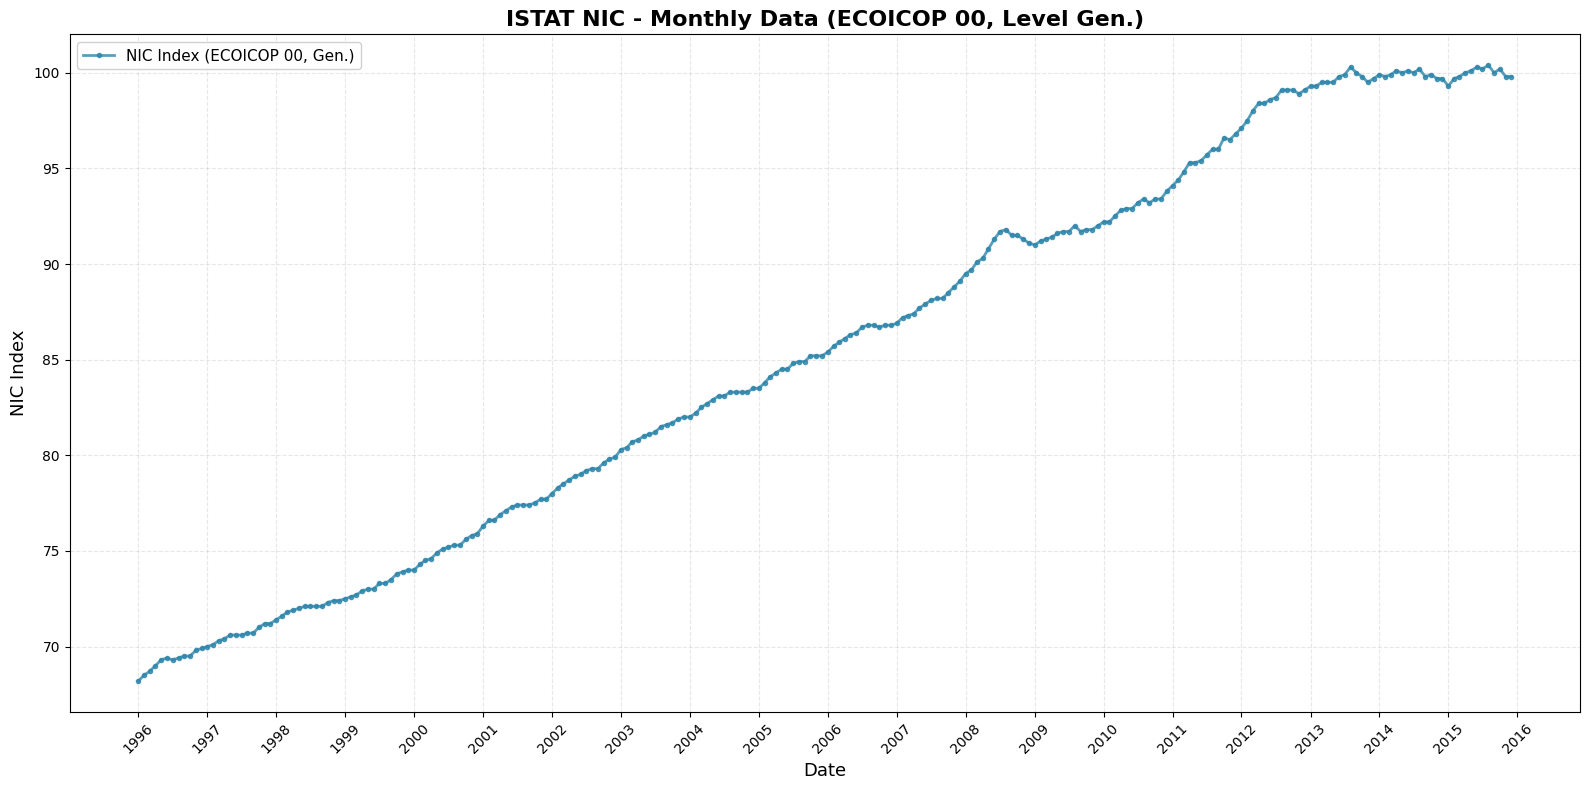


Plot created successfully!


In [5]:
# Create plot
print(f"\n{'='*60}")
print("Creating plot...")
print(f"{'='*60}")

# Convert TIME_PERIOD to datetime for plotting
df['DATE'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y-%m')

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df['DATE'], df['OBS_VALUE'], 
        label='NIC Index (ECOICOP 00, Gen.)', linewidth=2, color='#2E86AB', alpha=0.8, marker='o', markersize=3)

ax.set_title('ISTAT NIC - Monthly Data (ECOICOP 00, Level Gen.)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('NIC Index', fontsize=13)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(1))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

# Save the plot
plot_file = os.path.join(output_dir, 'NIC_MONTHLY_plot.png')
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"\nPlot saved: {plot_file}")

plt.show()

print(f"\n{'='*60}")
print("Plot created successfully!")
print(f"{'='*60}")


## Extract Data from NIC_2016_2025M11.tar.gz

Extract data from the compressed file for the period 2016-2025.


In [6]:
import tarfile
import tempfile

# Extract and read data from tar.gz file
tar_file = 'data/istat/NIC_2016_2025M11.tar.gz'

print(f"\n{'='*60}")
print("Extracting data from tar.gz file...")
print(f"{'='*60}")

if not os.path.exists(tar_file):
    raise FileNotFoundError(f"File not found: {tar_file}")

# Initialize df_new outside the context manager
df_new = None

# Extract to temporary directory
with tempfile.TemporaryDirectory() as tmpdir:
    with tarfile.open(tar_file, 'r:gz') as tar:
        tar.extractall(tmpdir)
        
        # Find the CSV file
        csv_files = [f for f in os.listdir(tmpdir) if f.endswith('.csv')]
        if not csv_files:
            raise FileNotFoundError("No CSV file found in tar.gz archive")
        
        csv_path = os.path.join(tmpdir, csv_files[0])
        print(f"Extracted CSV file: {csv_files[0]}")
        
        # Read the CSV file
        # Handle potential parsing errors due to malformed lines
        print(f"\nReading CSV file...")
        try:
            # Try reading with error handling for bad lines
            df_tar = pd.read_csv(csv_path, on_bad_lines='skip', low_memory=False, encoding='utf-8')
        except TypeError:
            # For older pandas versions, use error_bad_lines parameter
            try:
                df_tar = pd.read_csv(csv_path, error_bad_lines=False, warn_bad_lines=True, low_memory=False, encoding='utf-8')
            except Exception as e:
                # Last resort: try with different encoding and skip bad lines
                print(f"Warning: Error reading with utf-8, trying latin-1: {e}")
                df_tar = pd.read_csv(csv_path, on_bad_lines='skip', low_memory=False, encoding='latin-1')
        
        print(f"CSV file shape: {df_tar.shape}")
        print(f"Columns: {df_tar.columns.tolist()}")
        
        # Filter data according to requirements:
        # - Territorio = Italia
        # - MEASURE = 4
        # - E_COICOP_REV_ISTAT = '00' (string, not integer!)
        # - ECOICOP Rev. Istat = Indice generale
        print(f"\n{'='*60}")
        print("Filtering data...")
        print(f"{'='*60}")
        
        # Check unique values for debugging
        print(f"E_COICOP_REV_ISTAT unique values (first 5): {df_tar['E_COICOP_REV_ISTAT'].unique()[:5]}")
        print(f"E_COICOP_REV_ISTAT dtype: {df_tar['E_COICOP_REV_ISTAT'].dtype}")
        
        df_filtered = df_tar[
            (df_tar['Territorio'] == 'Italia') &
            (df_tar['MEASURE'] == 4) &
            (df_tar['E_COICOP_REV_ISTAT'] == '00') &  # String '00', not integer 0
            (df_tar['ECOICOP Rev. Istat'] == 'Indice generale')
        ].copy()
        
        print(f"Filtered data shape: {df_filtered.shape}")
        print(f"\nFirst few rows:")
        print(df_filtered[['TIME_PERIOD', 'Osservazione']].head(10))
        print(f"\nLast few rows:")
        print(df_filtered[['TIME_PERIOD', 'Osservazione']].tail(10))
        
        # Extract TIME_PERIOD and Osservazione
        df_new = df_filtered[['TIME_PERIOD', 'Osservazione']].copy()
        df_new.columns = ['TIME_PERIOD', 'OBS_VALUE']
        
        # Ensure OBS_VALUE is numeric
        df_new['OBS_VALUE'] = pd.to_numeric(df_new['OBS_VALUE'], errors='coerce')
        
        # Remove rows with missing values
        df_new = df_new.dropna()
        
        # Sort by TIME_PERIOD
        df_new = df_new.sort_values(by='TIME_PERIOD').reset_index(drop=True)

print(f"\n{'='*60}")
print("Extracted data summary:")
print(f"{'='*60}")
print(f"Shape: {df_new.shape}")
print(f"Time period range: {df_new['TIME_PERIOD'].min()} to {df_new['TIME_PERIOD'].max()}")
print(f"\nFirst 10 rows:")
print(df_new.head(10))
print(f"\nLast 10 rows:")
print(df_new.tail(10))

print(f"\nData extraction completed!")



Extracting data from tar.gz file...
Extracted CSV file: NIC_2016_2025M11.csv

Reading CSV file...
CSV file shape: (132110, 30)
Columns: ['FREQ', 'Frequenza', 'REF_AREA', 'Territorio', 'DATA_TYPE', 'Indicatore', 'MEASURE', 'Misura', 'E_COICOP_REV_ISTAT', 'ECOICOP Rev. Istat', 'TIME_PERIOD', 'Osservazione', 'OBS_STATUS', '\'Stato dell"\'osservazione\'', 'NOTE_REF_AREA', 'Territorio (NOTE_REF_AREA)', 'NOTE_DATA_TYPE', 'Indicatore (NOTE_DATA_TYPE)', 'NOTE_MEASURE', 'Misura (NOTE_MEASURE)', 'NOTE_E_COICOP_REV_ISTAT', 'ECOICOP Rev. Istat (NOTE_E_COICOP_REV_ISTAT)', 'NOTE_TIME_PERIOD', 'Tempo (NOTE_TIME_PERIOD)', 'BASE_PER', 'Anno base', 'UNIT_MEAS', 'Unità di misura', 'UNIT_MULT', 'Unità di moltiplicazione']

Filtering data...
E_COICOP_REV_ISTAT unique values (first 5): ['00' '01' '02' '03' '06']
E_COICOP_REV_ISTAT dtype: object
Filtered data shape: (119, 30)

First few rows:
  TIME_PERIOD  Osservazione
0     2016-01          99.6
1     2016-02          99.4
2     2016-03          99.6
3   

## Plot New Series (2016-2025)

Create a plot of the extracted data from the tar.gz file.



Creating plot for new series (2016-2025)...

Plot saved: data/istat/NIC_MONTHLY_2016_2025_plot.png


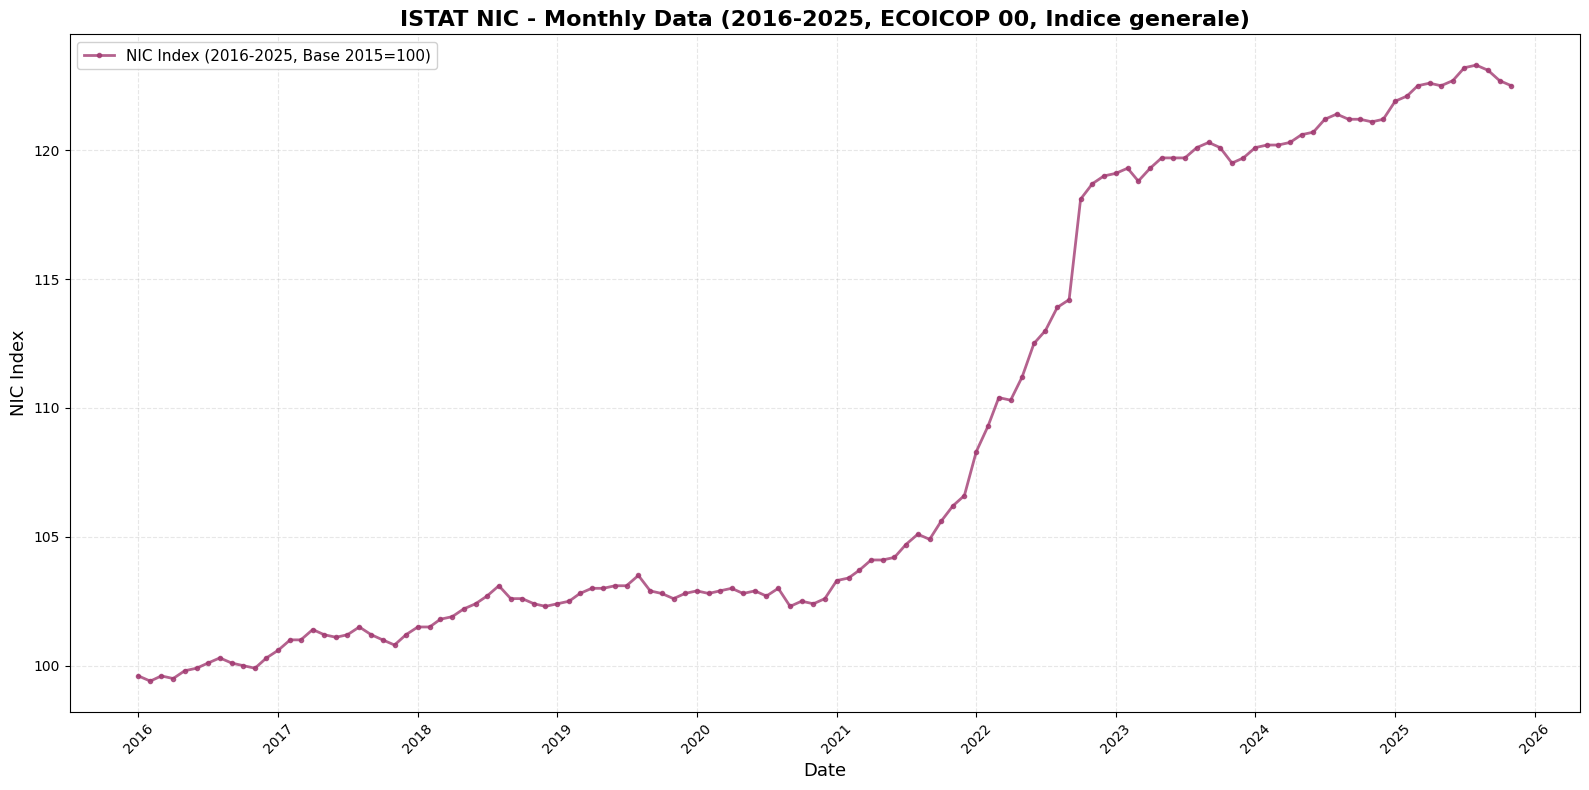


Plot created successfully!


In [7]:
# Create plot for the new series
print(f"\n{'='*60}")
print("Creating plot for new series (2016-2025)...")
print(f"{'='*60}")

# Convert TIME_PERIOD to datetime for plotting
df_new['DATE'] = pd.to_datetime(df_new['TIME_PERIOD'], format='%Y-%m')

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df_new['DATE'], df_new['OBS_VALUE'], 
        label='NIC Index (2016-2025, Base 2015=100)', linewidth=2, color='#A23B72', alpha=0.8, marker='o', markersize=3)

ax.set_title('ISTAT NIC - Monthly Data (2016-2025, ECOICOP 00, Indice generale)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('NIC Index', fontsize=13)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(1))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

# Save the plot
plot_file_new = os.path.join(output_dir, 'NIC_MONTHLY_2016_2025_plot.png')
plt.savefig(plot_file_new, dpi=150, bbox_inches='tight')
print(f"\nPlot saved: {plot_file_new}")

plt.show()

print(f"\n{'='*60}")
print("Plot created successfully!")
print(f"{'='*60}")


## Merge Series and Create Final Plot

Merge the two series (1996-2015 from Excel and 2016-2025 from tar.gz) and create a plot showing where one series ends and the other begins.


In [8]:
# Merge the two series
print(f"\n{'='*60}")
print("Merging series...")
print(f"{'='*60}")

# Read the existing NIC_MONTHLY.csv file
existing_file = os.path.join(output_dir, 'NIC_MONTHLY.csv')
if os.path.exists(existing_file):
    df_existing = pd.read_csv(existing_file)
    print(f"\nExisting series (from Excel):")
    print(f"  Shape: {df_existing.shape}")
    print(f"  Time period range: {df_existing['TIME_PERIOD'].min()} to {df_existing['TIME_PERIOD'].max()}")
    print(f"  First few rows:")
    print(df_existing.head())
    print(f"  Last few rows:")
    print(df_existing.tail())
    
    # Add a source column to track which series each row comes from
    df_existing['SOURCE'] = '1996-2015 (Excel)'
    df_new['SOURCE'] = '2016-2025 (tar.gz)'
    
    # Merge the two dataframes
    df_merged = pd.concat([df_existing, df_new], ignore_index=True)
    
    # Sort by TIME_PERIOD
    df_merged = df_merged.sort_values(by='TIME_PERIOD').reset_index(drop=True)
    
    print(f"\n{'='*60}")
    print("Merged series:")
    print(f"{'='*60}")
    print(f"  Shape: {df_merged.shape}")
    print(f"  Time period range: {df_merged['TIME_PERIOD'].min()} to {df_merged['TIME_PERIOD'].max()}")
    print(f"\n  Source distribution:")
    print(df_merged['SOURCE'].value_counts())
    
    # Find the transition point
    transition_idx = df_merged[df_merged['SOURCE'] == '2016-2025 (tar.gz)'].index[0]
    transition_date = df_merged.iloc[transition_idx]['TIME_PERIOD']
    print(f"\n  Transition point: {transition_date}")
    print(f"  Last value from Excel series: {df_merged.iloc[transition_idx - 1]['OBS_VALUE']}")
    print(f"  First value from tar.gz series: {df_merged.iloc[transition_idx]['OBS_VALUE']}")
    
    # Save merged file
    output_file_merged = os.path.join(output_dir, 'NIC_MONTHLY.csv')
    df_merged[['TIME_PERIOD', 'OBS_VALUE']].to_csv(output_file_merged, index=False)
    print(f"\n  Merged file saved: {output_file_merged}")
    
else:
    print(f"\nWarning: Existing file {existing_file} not found. Using only new series.")
    df_merged = df_new.copy()
    df_merged['SOURCE'] = '2016-2025 (tar.gz)'
    output_file_merged = os.path.join(output_dir, 'NIC_MONTHLY.csv')
    df_merged[['TIME_PERIOD', 'OBS_VALUE']].to_csv(output_file_merged, index=False)
    print(f"  New file saved: {output_file_merged}")



Merging series...

Existing series (from Excel):
  Shape: (240, 2)
  Time period range: 1996-01 to 2015-12
  First few rows:
  TIME_PERIOD  OBS_VALUE
0     1996-01       68.2
1     1996-02       68.5
2     1996-03       68.7
3     1996-04       69.0
4     1996-05       69.3
  Last few rows:
    TIME_PERIOD  OBS_VALUE
235     2015-08      100.4
236     2015-09      100.0
237     2015-10      100.2
238     2015-11       99.8
239     2015-12       99.8

Merged series:
  Shape: (359, 4)
  Time period range: 1996-01 to 2025-11

  Source distribution:
SOURCE
1996-2015 (Excel)     240
2016-2025 (tar.gz)    119
Name: count, dtype: int64

  Transition point: 2016-01
  Last value from Excel series: 99.8
  First value from tar.gz series: 99.6

  Merged file saved: data/istat/NIC_MONTHLY.csv



Creating final merged plot...

Plot saved: data/istat/NIC_MONTHLY_merged_plot.png


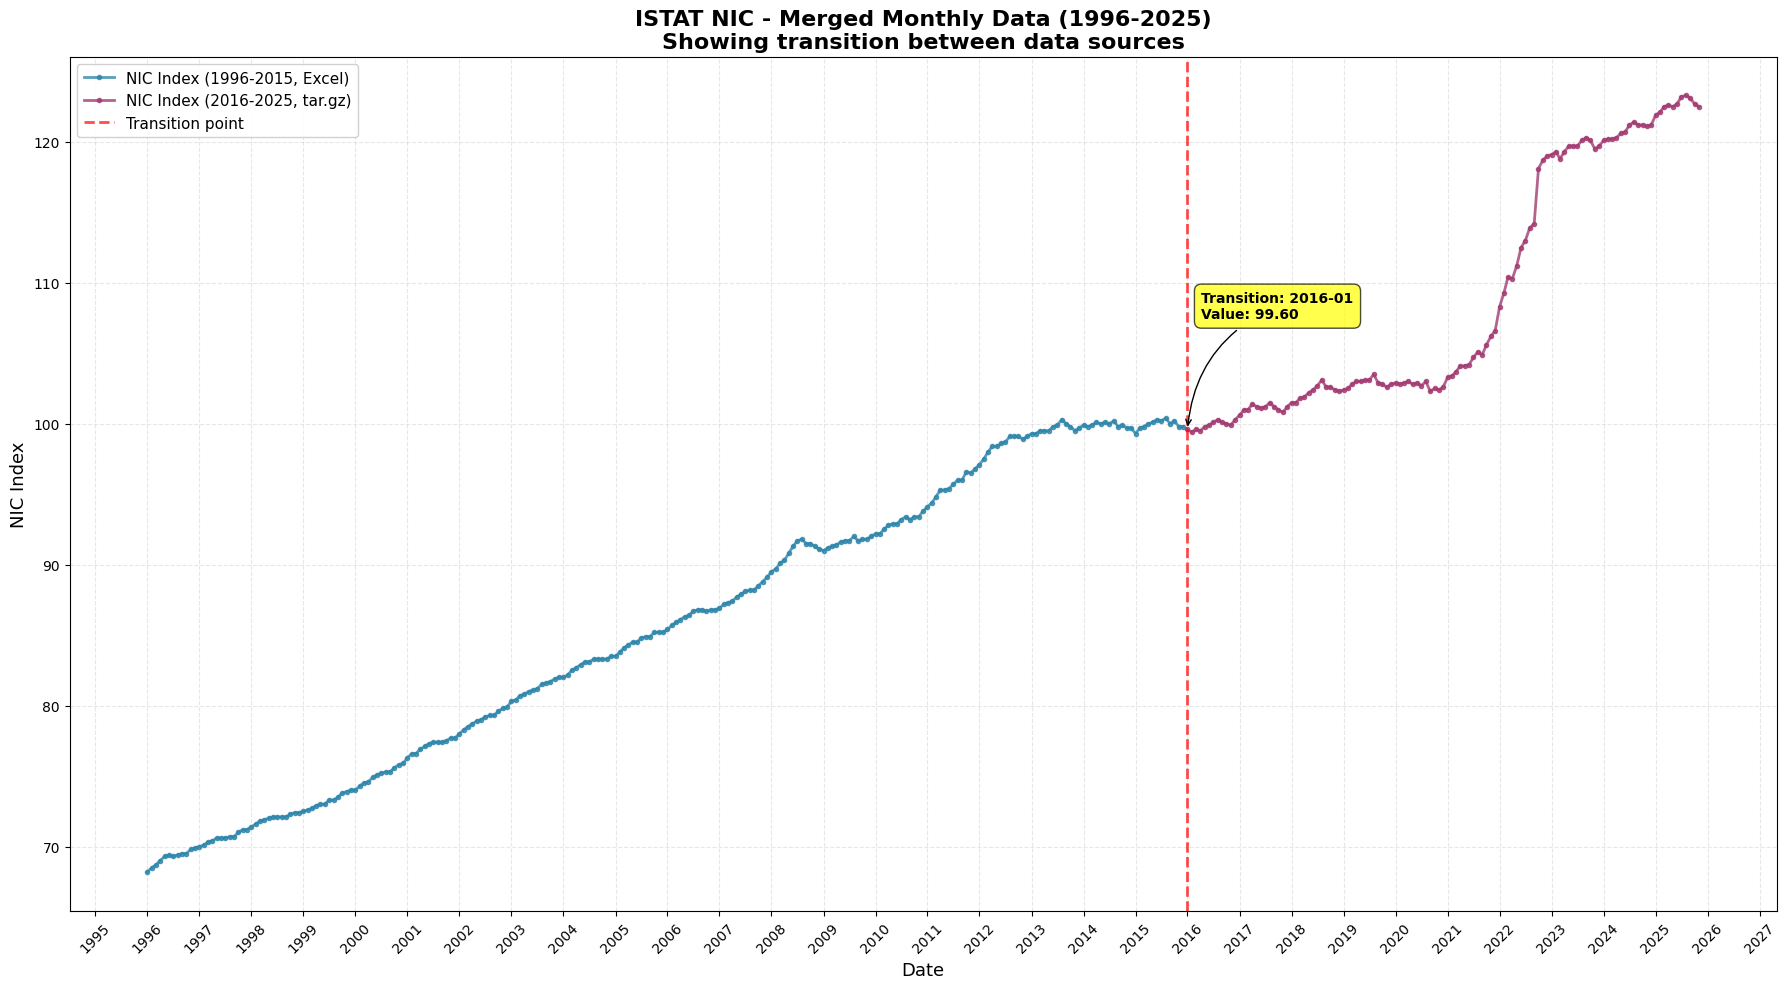


Final plot created successfully!


In [9]:
# Create final plot showing both series and transition point
print(f"\n{'='*60}")
print("Creating final merged plot...")
print(f"{'='*60}")

# Convert TIME_PERIOD to datetime for plotting
df_merged['DATE'] = pd.to_datetime(df_merged['TIME_PERIOD'], format='%Y-%m')

# Split by source for plotting
df_existing_plot = df_merged[df_merged['SOURCE'] == '1996-2015 (Excel)'].copy() if '1996-2015 (Excel)' in df_merged['SOURCE'].values else None
df_new_plot = df_merged[df_merged['SOURCE'] == '2016-2025 (tar.gz)'].copy()

# Create the plot
fig, ax = plt.subplots(figsize=(18, 10))

# Plot each series with different colors
if df_existing_plot is not None and len(df_existing_plot) > 0:
    ax.plot(df_existing_plot['DATE'], df_existing_plot['OBS_VALUE'], 
            label='NIC Index (1996-2015, Excel)', linewidth=2, color='#2E86AB', alpha=0.8, marker='o', markersize=3)

ax.plot(df_new_plot['DATE'], df_new_plot['OBS_VALUE'], 
        label='NIC Index (2016-2025, tar.gz)', linewidth=2, color='#A23B72', alpha=0.8, marker='o', markersize=3)

# Mark the transition point
if df_existing_plot is not None and len(df_existing_plot) > 0:
    transition_date = df_new_plot['DATE'].iloc[0]
    transition_value = df_new_plot['OBS_VALUE'].iloc[0]
    
    # Add vertical line at transition
    ax.axvline(x=transition_date, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Transition point')
    
    # Add annotation (positioned at top of plot)
    ax.annotate(f'Transition: {transition_date.strftime("%Y-%m")}\nValue: {transition_value:.2f}',
                xy=(transition_date, transition_value),
                xytext=(10, 80), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'),
                fontsize=10, fontweight='bold')

ax.set_title('ISTAT NIC - Merged Monthly Data (1996-2025)\nShowing transition between data sources', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('NIC Index', fontsize=13)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(1))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

# Save the plot
plot_file_merged = os.path.join(output_dir, 'NIC_MONTHLY_merged_plot.png')
plt.savefig(plot_file_merged, dpi=150, bbox_inches='tight')
print(f"\nPlot saved: {plot_file_merged}")

plt.show()

print(f"\n{'='*60}")
print("Final plot created successfully!")
print(f"{'='*60}")
